In [1]:
#либы
import matplotlib.pyplot as plt
import os
import PIL
import PIL.Image
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

import shutil
import numpy as np
import tensorflow_hub as hub
import tensorflow_text as text
import json

from os import listdir
from os.path import isfile, join

In [2]:
#загрузка bert - модели
tfhub_handle_encoder = 'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1'
tfhub_handle_preprocess = 'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3'
bert_preprocess_model = hub.KerasLayer(tfhub_handle_preprocess)
bert_model = hub.KerasLayer(tfhub_handle_encoder)

In [3]:
#каталоги json-a и картинок
json_dir = "C:/users/user/AI tests/Autoencoder tests/datasets/annotations/captions_train2014.json"
images_dir = "C:/users/user/AI tests/Autoencoder tests/datasets/train2014/"

#функции работы с текстом и картинками
def bert_text(text_batch):
    text_preprocessed = bert_preprocess_model(text_batch)
    bert_results = bert_model(text_preprocessed)
    return bert_results["pooled_output"]

def load_imgs(img_batch):
    img = tf.io.read_file(img_batch)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, (16, 16))
    img = tf.cast(img, tf.float32) / 255
    return img

#создаем массив подписей и путей к картинкам
array_of_annotations = []
array_of_filenames = []
with open(json_dir, 'r') as f:
    json_data = json.load(f)
    
    #обработаем n картинок
    n = 100
    for i in range(n):
        array_of_annotations.append(json_data["annotations"][i]["caption"])
        num = json_data["annotations"][i]["image_id"]
        array_of_filenames.append(images_dir+"COCO_train2014_"+str(num).rjust(12, '0') + ".jpg")
        
    annotation_dataset = tf.data.Dataset.from_tensor_slices(array_of_annotations)
    filename_dataset = tf.data.Dataset.from_tensor_slices(array_of_filenames)
    
    annotation_dataset = annotation_dataset.batch(1)
    bert_ann_dataset = annotation_dataset.map(bert_text)
    
    images_dataset = filename_dataset.map(load_imgs)

    
    dataset = tf.data.Dataset.zip((images_dataset, bert_ann_dataset, annotation_dataset))
    
    dataset = dataset.shuffle(1000).batch(64)
    
#датасет создан как "конвеер", сами данные еще не загружены.

[[ 0.95568776  0.98173785  0.24879874 -0.01880966  0.2611891   0.09982617
   0.9974348  -0.99841964 -0.6721416   0.8891193  -0.21220815 -0.9888354
   0.7094248  -0.9491994  -0.05070272  0.81869364 -0.34084004 -0.23260812
  -0.21695693  0.29119262  0.09816384 -0.17031243  0.4896174   0.6432251
   0.99331295  0.9344788  -0.06966708 -0.20336983 -0.14976683  0.8874067
  -0.20912641 -0.05646251  0.37261024 -0.17226091 -0.9708253  -0.14396098
  -0.21569878  0.05942491  0.7502159   0.11699387 -0.0804391  -0.34451059
   0.00550138 -0.980116   -0.09367716  0.9689963  -0.87670904 -0.07958714
   0.9694057  -0.4414469   0.97468406 -0.03048302  0.97225064  0.13604549
   0.592186    0.07856163  0.19259267 -0.58714277 -0.9947726  -0.97019905
   0.31952435  0.3381971   0.7969641  -0.376022   -0.08672476 -0.97330207
   0.995642    0.6122267  -0.4727573   0.9926465   0.9840114   0.9996327
  -0.90213174 -0.920753   -0.8864371  -0.2842922   0.13361508  0.93390894
  -0.16947506 -0.5262374  -0.84732866 -0.4

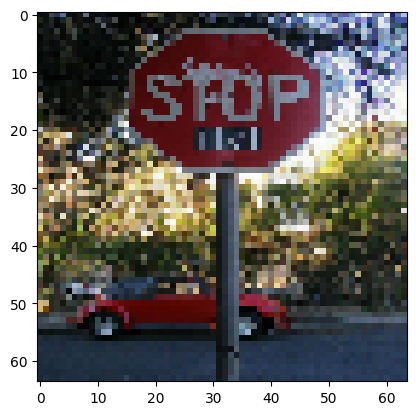

In [6]:
#отобразит одну из картинок, текстовый эмбеддинг и саму подпись (для проверки)
for a, b, c in dataset.take(1):
    plt.imshow(a[4])
    print(b[4].numpy())
    print(c[4].numpy())

In [4]:
#выполняется долго т.к. использует bert

#создаст tfrecord с таким названием
writer = tf.io.TFRecordWriter('dataset_10.tfrecord')

for a, b, c in dataset:
    print('batch')
    #сохраняем три параметра (картинка, эмбеддинг, подпись)
    serialized_a = tf.io.serialize_tensor(a).numpy()
    serialized_b = tf.io.serialize_tensor(b).numpy()
    serialized_c = tf.io.serialize_tensor(c).numpy()

    #создаем экземпляр
    example = tf.train.Example(features=tf.train.Features(feature={
        'a': tf.train.Feature(bytes_list=tf.train.BytesList(value=[serialized_a])),
        'b': tf.train.Feature(bytes_list=tf.train.BytesList(value=[serialized_b])),
        'c': tf.train.Feature(bytes_list=tf.train.BytesList(value=[serialized_c]))
    }))

    # записываем экземпляр в tfrecord файл
    writer.write(example.SerializeToString())

writer.close()

batch
batch


In [5]:
#пример чтения

dataset = tf.data.TFRecordDataset('dataset_1.tfrecord')

def parse_record(record):
    feature_description = {
        'a': tf.io.FixedLenFeature([], tf.string),
        'b': tf.io.FixedLenFeature([], tf.string),
        'c': tf.io.FixedLenFeature([], tf.string)
    }
    parsed_record = tf.io.parse_single_example(record, feature_description)
    
    a = tf.io.parse_tensor(parsed_record['a'], out_type=tf.float32)
    b = tf.io.parse_tensor(parsed_record['b'], out_type=tf.float32)
    c = tf.io.parse_tensor(parsed_record['c'], out_type=tf.string)
    
    return a, b, c

dataset = dataset.map(parse_record)